# Provider Fraud Detection: Modeling Outputs 

## This notebook takes the preprocessed dataset developed in Preprocessing + Feature Engineering script and runs the dataset through a series of models to determine the optimal modeling technique 

## Load required packages

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import pickle
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
# Importing Classifier Modules
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV

## Import and review revised dataset 

In [2]:
#load data
df = pd.read_csv('provider_data.csv')
df.head()

,Provider,Fraud,reimburse_mean,deductible_mean,days_admitted_mean,num_diagnoses_mean,num_procedures_mean,reimburse_median,deductible_median,days_admitted_median,...,chroniccond_ischemicheart,chroniccond_osteoporasis,chroniccond_rheumatoidarthritis,chroniccond_stroke,renal_disease,gender,race_1,race_2,race_3,race_4
0,PRV51001,0,4185.600000,213.600000,2.440000,3.200000,0.120000,400,0.0,1.0,...,0.920000,0.240000,0.320000,0.240000,0.320000,0.360000,0.840000,0.160000,0.000000,0.000000
1,PRV51003,1,4588.409091,502.166667,4.674242,5.250000,0.363636,1750,0.0,2.5,...,0.848485,0.250000,0.287879,0.090909,0.219697,0.409091,0.810606,0.181818,0.000000,0.007576
2,PRV51004,0,350.134228,2.080537,2.429530,2.583893,0.000000,70,0.0,1.0,...,0.724832,0.328859,0.308725,0.114094,0.154362,0.308725,0.805369,0.161074,0.033557,0.000000
3,PRV51005,1,241.124464,3.175966,2.088412,2.588841,0.000000,70,0.0,1.0,...,0.768240,0.295279,0.284120,0.106438,0.222318,0.438627,0.766524,0.224893,0.008584,0.000000
4,PRV51007,0,468.194444,45.333333,1.958333,2.986111,0.013889,80,0.0,1.0,...,0.708333,0.291667,0.305556,0.166667,0.152778,0.472222,0.805556,0.194444,0.000000,0.000000


## Run dataset through standard scaling, remove Fraud and Provider indicators 

In [7]:
# Conduct Standard Scaling 
sc_X = StandardScaler()
X =  pd.DataFrame(sc_X.fit_transform(df.drop(["Provider", "Fraud"],axis = 1),), columns=['reimburse_mean', 'deductible_mean',
 'days_admitted_mean', 'num_diagnoses_mean', 'num_procedures_mean',
 'reimburse_median', 'deductible_median', 'days_admitted_median',
 'num_diagnoses_median', 'num_procedures_median', 'reimburse_max',
 'deductible_max', 'days_admitted_max', 'num_diagnoses_meax',
 'num_procedures_max', 'age_mean', 'age_median', 'outpatient_proportion',
 'chroniccond_alzheimer', 'chroniccond_heartfailure',
 'chroniccond_kidneydisease', 'chroniccond_cancer',
 'chroniccond_obstrpulmonary', 'chroniccond_depression',
 'chroniccond_diabetes', 'chroniccond_ischemicheart',
 'chroniccond_osteoporasis', 'chroniccond_rheumatoidarthritis',
 'chroniccond_stroke', 'renal_disease', 'gender', 'race_1', 'race_2', 'race_3',
 'race_4'])
X.head()

,reimburse_mean,deductible_mean,days_admitted_mean,num_diagnoses_mean,num_procedures_mean,reimburse_median,deductible_median,days_admitted_median,num_diagnoses_median,num_procedures_median,...,chroniccond_ischemicheart,chroniccond_osteoporasis,chroniccond_rheumatoidarthritis,chroniccond_stroke,renal_disease,gender,race_1,race_2,race_3,race_4
0,0.701726,0.189223,-0.278969,-0.120048,0.048681,-0.177520,-0.354849,-0.295778,-0.432435,-0.248712,...,1.001660,-0.470620,0.064710,1.190937,0.838351,-0.325909,-0.047892,0.522189,-0.436844,-0.380702
1,0.817338,1.130897,0.806916,1.066796,1.037938,0.275848,-0.354849,0.490155,0.756684,-0.248712,...,0.536981,-0.412316,-0.125871,-0.120725,0.155985,-0.055537,-0.245397,0.700243,-0.436844,-0.248318
2,-0.399106,-0.501024,-0.284057,-0.476743,-0.438565,-0.288343,-0.354849,-0.295778,-0.432435,-0.248712,...,-0.266468,0.047468,-0.002188,0.083249,-0.288490,-0.608312,-0.280585,0.530952,-0.018891,-0.380702
3,-0.430393,-0.497449,-0.449847,-0.473878,-0.438565,-0.288343,-0.354849,-0.295778,-0.432435,-0.248712,...,0.015582,-0.148319,-0.148172,0.015892,0.173813,0.107133,-0.541597,1.051766,-0.329934,-0.380702
4,-0.365221,-0.359878,-0.513068,-0.243879,-0.382171,-0.284985,-0.354849,-0.295778,-0.432435,-0.248712,...,-0.373671,-0.169380,-0.020991,0.545770,-0.299270,0.292164,-0.279333,0.803284,-0.436844,-0.380702


## Develop target outcome variable

In [8]:
# Establish Target Outcome Variable 
Y = df.Fraud
Y

0       0
1       1
2       0
3       1
4       0
       ..
5405    0
5406    0
5407    0
5408    0
5409    0
Name: Fraud, Length: 5410, dtype: int64

## Split dataset for training/testing 

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.20, random_state=42)

## Run features through random forest to determine feature importance

In [10]:
# Produce and save the model, then load and apply the model.
rfr = RandomForestRegressor()
rfr.fit(X_train, Y_train)
rfr_predictions = rfr.predict(X_test)
rfr_score = round(rfr.score(X_test, Y_test) * 100, 2)
rfr_score

39.31

<AxesSubplot:>

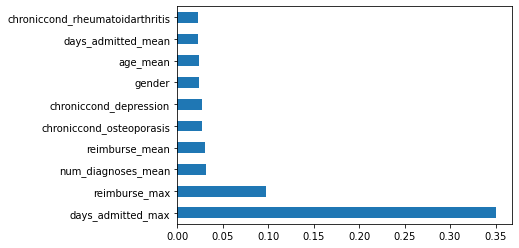

In [19]:
feat_importances = pd.Series(rfr.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [21]:
feat_importances.sort_values(ascending=False)

days_admitted_max                  0.350571
reimburse_max                      0.097762
num_diagnoses_mean                 0.031480
reimburse_mean                     0.030408
chroniccond_osteoporasis           0.027261
chroniccond_depression             0.026830
gender                             0.024374
age_mean                           0.023421
days_admitted_mean                 0.023152
chroniccond_rheumatoidarthritis    0.022522
renal_disease                      0.022144
chroniccond_diabetes               0.021954
chroniccond_cancer                 0.021075
chroniccond_stroke                 0.020916
chroniccond_alzheimer              0.020100
chroniccond_ischemicheart          0.019993
chroniccond_obstrpulmonary         0.019701
chroniccond_heartfailure           0.019269
race_3                             0.018686
race_2                             0.018183
num_diagnoses_meax                 0.017602
race_1                             0.017334
chroniccond_kidneydisease       